In [598]:
import csv
import pandas
import numpy as np
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import datetime as p_datetime
from statsmodels.tsa.arima_model import ARIMA
from pandas.tools.plotting import autocorrelation_plot
%matplotlib inline 

## Constants

In [35]:
STATION_ID_COL_NAME = 'station id'
STATION_NAME_COL_NAME = 'station name'
PARAM_T = 'T [°C]'
PARAM_RAIN = 'količina padavin [mm]'

## Initial Configuration (not in use)

## Helper Functions

In [506]:
def ARSO_datetime_to_epoch(datetime_string):
    """Convert ARSO datetime into epoch time in seconds."""
    try:
        utc_time = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M")
    except:
        utc_time = datetime.strptime(datetime_string, "%Y-%m-%d")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time


def ARSO_datetime_to_epoch_array(datetime_strings):
    """Convert list of ARSO datetimes into epoch time in seconds."""
    return [ARSO_datetime_to_epoch(dt) for dt in datetime_strings]


def synchronize_date(date_string):
    """Convert datetime into common form using dots."""
    date_string = date_string.replace('/', '.')
    date_string = date_string.replace('-', '.')
    date_string = date_string.replace('Feb', '2')
    return date_string

def synchronize_time(time_string):
    time_string = time_string.replace(':00', '')
    return time_string

def borzen_datetime_to_datetime(datetime_string):
    """Convert borzen datetime in string into datetime object."""
    # synchronize all dates
    tmp = datetime_string.split(" ")
    date = tmp[0]
    if len(date) < 6: # Example 1.1.02
        print("Error in date parsing " + date + " in datetime " + datetime_string)
        return
    time = tmp[-1]
    if len(date) < 1: # Example 1
        print("Error in time parsing " + time + " in datetime " + datetime_string)
        return
    date = synchronize_date(date)
    time = synchronize_time(time)
    datetime_string = date + " " + time
    # convert to epoch
    try:
        utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
        return utc_time
    except:
        # strptime accepts [0,23] hour interval, while borzen data has [1,24] hour 
        # interval, thus modification of '24' into '00' is needed
        if datetime_string[-2:] == "24":
            datetime_string = datetime_string[:-2] + "00"
            utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
            return utc_time
        else:
            print("Error in datetime parsing: " + datetime_string)

def datetime_to_epoch(datetime_):
    """Convert borzen datetime into epoch time in seconds."""
    epoch_time = (datetime_ - datetime(1970, 1, 1)).total_seconds()
    return epoch_time

## Classes

In [54]:
class Station:
    """Holds all informations about weather station."""
    def __init__(self, station_id, station_name, header, data, data_timestamp_epoch):
        self.station_is = station_id
        self.station_name = station_name
        self.header = header
        self.data = data
        self.size = len(data)
        self.data_ts = data_timestamp_epoch
    
    def __str__(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)
    
    def __repr(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)

In [55]:
class Prices:
    """Holds prices and corresponding timestamps."""
    def __init__(self, prices, prices_timestamp_epoch):
        self.prices = prices
        self.timestamps = prices_timestamp_epoch

## Load Data

In [63]:
def test_load_ksedlo():
    """Load weather data for Korenjsko sedlo that has been dowloaded 
    from ARSO website. It removes lines that have any NaN values."""
    print('Start loading korenjsko sedlo')
    test_file_ksedlo = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                        'MatematikaZracunalnikom/WeatherDataTest/KorenjskoSedloTest'
    # open file and read content in a csv format
    csvfile = open(test_file_ksedlo, 'r')
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)
    # extract header and clean up data by removing empty lines
    header_line = [el.strip() for el in data[0]]
    station_id = header_line[0]
    station_name = header_line[1]
    header = header_line[2:]
    # there are empty lines generated by parsing that needs to be removed
    data_full = data[2:len(data):2]
    data_empty = data[1:len(data):2]
    # check if 'empty' lines are really empty
    for lst in data_empty:
        if len(lst) != 0:
            # there is a non empty line
            print("Warning: not empty line " + lst)
            return None
    # remove station_id column, station_name column and datatime 
    # and create numpy matrix with floats
    data_clean = []
    for line in data_full:
        try:
            line_clean_float = list(map(float, line[3:]))
            data_clean.append(line_clean_float)
        except:
            # lines that have missing values are removed
            pass
    data_clean_np = np.array(data_clean)
    # extract datetime and convert it into timestamp epoch
    data_timestamps = np.array([[ARSO_datetime_to_epoch(line[2])] 
                                for line in data_full])
    # finish
    print('Loading successful')
    return Station(station_id, station_name, header, data_clean_np, data_timestamps)

In [216]:
def test_load_pucnik(file_name = None):
    """Load weather data for Joze Pucnik airport that has been dowloaded 
    from ARSO website."""
    print('Start loading joze pucnik')
    if file_name == None:
        file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                    'MatematikaZracunalnikom/WeatherDataTest/JozePucnikDailyData'
    # open file and read content in a csv format
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)
    # extract header and clean up data by removing empty lines
    header_line = [el.strip() for el in data[0]]
    station_id = header_line[0]
    station_name = header_line[1]
    header = header_line[2:]
    # there are empty lines generated by parsing that needs to be removed
    data_full = data[2:len(data):2]
    data_empty = data[1:len(data):2]
    # check if 'empty' lines are really empty
    for lst in data_empty:
        if len(lst) != 0:
            # there is a non empty line
            print("Warning: not empty line " + lst)
            return None
    # remove station_id column, station_name column and datatime 
    # and create numpy matrix with floats
    data_clean = []
    for line in data_full:
        try:
            line_clean_float = list(map(float, line[3:]))
            data_clean.append(line_clean_float)
        except:
            # lines that have missing values are removed
            pass
    data_clean_np = np.array(data_clean)
    # extract datetime and convert it into timestamp epoch
    data_timestamps = np.array([[ARSO_datetime_to_epoch(line[2])] 
                                for line in data_full])
    # finish
    print('Loading successful')
    return Station(station_id, station_name, header, data_clean_np, data_timestamps)

In [65]:
def test_load_borzen_consumption():
    """Load power consumption of various suppliers."""
    print("Load test borzen consumption.")
    file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                'MatematikaZracunalnikom/Borzen/Odjem/PDO_PRO_ODJ_2016.csv/01 2016-Table 1.csv'
    # open file and read content in a csv format
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    # get header and clean data
    data = list(reader)
    header = data[7]
    data_clean = data[9:]
    # finish
    print("Loading test borzen consumption successful!")
    return Table(header, data_clean)

In [66]:
def test_load_borzen_price_january(b_timestamp = True):
    """Load borzen power prices."""
    print("Load test borzen prices.")
    file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                'MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    timestamps = []
    prices = []
    for line in data_clean:
        datetime = line[0]
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(datetime)
            datetime = datetime_to_epoch(datetime) 
        timestamps.append(datetime)
        prices.append(float(line[1].strip().replace(",",".")))
    # convert list into numpy array
    timestamps = np.array(timestamps)
    prices = np.array(prices)
    # finish
    print("Loading test borzen prices successful!")
    # TODO 
    return Prices(prices, timestamps)

In [67]:
def load_borzen_table(file_name, b_timestamp = True):
    """Load borzen power prices."""
    file_name_ = file_name.split("/")[-1]
    print("Load " + file_name_)
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    values = None
    for line in data_clean:
        datetime = line[0]
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(line[0])
            datetime = datetime_to_epoch(datetime)
        price = float(line[1].strip().replace(",","."))
        try:
            values = np.vstack((values, [datetime, price]))
        except:
            # assign directly at the beginning
            values = np.array([datetime, price])
    # finish
    print("Loading prices successful!")
    return np.array(values)

In [68]:
def load_borzen_tables(b_timestamp = True):
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/01 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/02 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/03 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/04 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/05 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/06 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/07 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/08 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/09 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/10 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/11 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/12 2016-Table 1.csv'
        #'/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    ]
    
    values = None
    for file_name in file_names:
        result = load_borzen_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

In [507]:
load_borzen_tables()

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!


array([[  1.45161000e+09,   4.96200000e+01],
       [  1.45161360e+09,   4.35000000e+01],
       [  1.45161720e+09,   3.86300000e+01],
       ..., 
       [  1.48322160e+09,   3.30200000e+01],
       [  1.48322520e+09,   3.37100000e+01],
       [  1.48314240e+09,   4.60000000e+01]])

In [542]:
def load_borzen_consumption_table(file_name, b_timestamp = True, debug=False):
    """Load borzen power prices."""
    file_name_ = file_name.split("/")[-1]
    print("Load " + file_name_)
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    values = None
    for line in data_clean:
        datetime = line[0]
        if len(datetime) < 8: # Example 1.1.92 1 
            if debug:
                print("Warning: This line has been skipped - " + str(line))
            continue
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(line[0])
            datetime = datetime_to_epoch(datetime)
        # Convert string numbers into float type and sum up consumption of all listed consumers
        try:
            consumption = sum([float(number.strip().replace(",",".")) for number in line[1:] if number != ""])
        except:
            print("Error:Summing up the following numbers did not succeed " + str(line[1:]))
        try:
            values = np.vstack((values, [datetime, consumption]))
        except:
            # assign directly at the beginning
            values = np.array([datetime, consumption])
    # finish
    print("Loading prices successful!")
    return np.array(values)

In [524]:
def load_power_consumption_2016(b_timestamp = True):
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/'\
        'Borzen/Odjem/PDO_PRO_ODJ_2016.csv/0'+str(i) + ' 2016-Table 1.csv' 
        for i in range(1, 10)]
    # WARNING: December 2016 is missing
    file_names += [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/'\
        'Borzen/Odjem/PDO_PRO_ODJ_2016.csv/'+str(i) + ' 2016-Table 1.csv' 
        for i in range(10, 12)]
    #'/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'

    values = None
    for file_name in file_names:
        result = load_borzen_consumption_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

In [526]:
#load_power_consumption_2016()

# ARIMA Model

The example of using ARIMA model in python is described here:
http://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [12]:
# Load price data
prices = load_borzen_tables()
prices = Prices(prices[:, 1], prices[:, 0])

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!


## Load and check data

In [13]:
# generate pandas dataframe with prices and datetimes
d = {'price': prices.prices}
dt = pandas.to_datetime(prices.timestamps, unit = "s")
series = pandas.DataFrame(data=d, index = dt)
series.head()

,price
2016-01-01 01:00:00,49.62
2016-01-01 02:00:00,43.50
2016-01-01 03:00:00,38.63
2016-01-01 04:00:00,36.80
2016-01-01 05:00:00,34.50


## Timeseries data display 

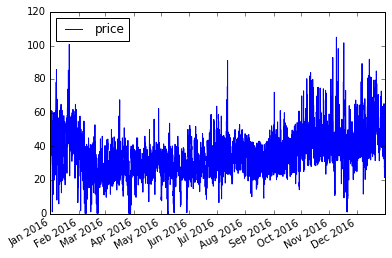

In [14]:
# plot timeseries
series.plot()

## Autocorrelation

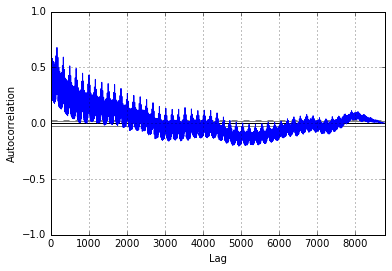

In [15]:
# plot autocorrelation
autocorrelation_plot(series)

## Fit ARIMA model

In [16]:
# fit ARIMA model and display summary
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8783
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -27532.093
Method:                       css-mle   S.D. of innovations              5.561
Date:                Wed, 19 Apr 2017   AIC                          55078.187
Time:                        18:38:04   BIC                          55127.751
Sample:                    01-01-2016   HQIC                         55095.073
                         - 12-31-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.635e-06      0.053     -0.000      1.000      -0.103       0.103
ar.L1.D.price     0.0450      0.011      4.234      0.000       0.024       0.066
ar.L2.D.price     0.0498      0.011     

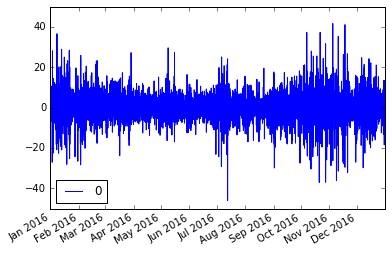

In [17]:
# plot residuals
residuals = pandas.DataFrame(model_fit.resid)
residuals.plot()

## Predict with ARIMA model

In [18]:
# fit ARIMA model
n = 48
fc_group = model_fit.forecast(n)

# extract array of forecasts, array of standard error and array of 95% confidence interval
fc = fc_group[0]
se = fc_group[1]
ci = fc_group[2]

In [19]:
# load true values
file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
true_values = load_borzen_table(file_name)

Load 01 2017-Table 1.csv
Loading prices successful!


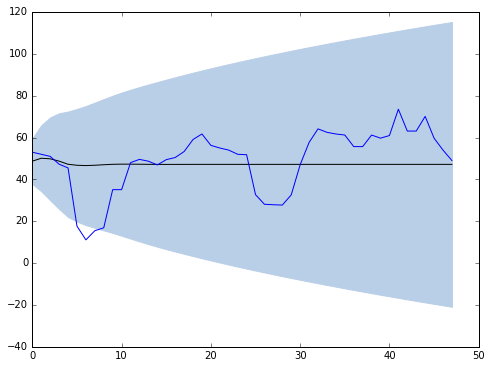

In [20]:
# compare forecast and true values
true_prices = true_values[:n, 1]

# fig size
fig, ax = pyplot.subplots(figsize=(8,6))

# plot data
x = range(0,len(fc))
ax.plot(x, fc, color = 'black')
ax.plot(x, true_prices, color = 'blue')

# plot confidence interval
ci_bottom = ci[:,0]
ci_top = ci[:,1]
ax.fill_between(x, ci_top, ci_bottom, color='#b9cfe7', edgecolor='')

# Models

## Helper functions

In [468]:
def plot_raw_and_predicted(raw_data, predicted_data, from_ = None, to_ = None):
    
    # check data length matching
    n = len(raw_data)
    m = len(predicted_data)
    if m != n:
        print("Error: raw_data length is " + n + " while predicted_data is " + m)
        
    # check input range parameters and set to deault if nothing passed
    if from_ == None:
        from_ = 0
    if to_ == None:
        to_ = n
    else:
        to_ = min(to_, n)

    # plot data
    fig, ax = pyplot.subplots(figsize=(40,6))
    range_ = range(from_,to_)
    ax.plot(range_, predicted_data[range_], color = 'blue')
    ax.plot(range_, raw_data[range_], color = 'black')

In [164]:
def split_datetime(datetimes):
    """Takes datetimes as an input and returns matrix with columns
    [hour, day, weekday, month]"""
    nn_datetime_np = np.array([])
    for nn_datetime in datetimes:
        nn_datetime = borzen_datetime_to_datetime(nn_datetime)
        tmp_arr = [nn_datetime.hour, nn_datetime.day, nn_datetime.weekday(), nn_datetime.month]
        try:
            nn_datetime_np = np.vstack((nn_datetime_np, tmp_arr))
        except:
            nn_datetime_np = np.array(tmp_arr)
    return nn_datetime_np

# Neural Networks

In [236]:
import sklearn
from sklearn.preprocessing import StandardScaler 

## Load data

In [412]:
def combine_pucnik_and_prices(weather_pucnik_data, X):
# (patch) multiply data rows by 24 (the number of hours in one day)
    tmp_list = []
    for sample in weather_pucnik_data:
        tmp_list += [sample]*24
    weather_pucnik_mul = np.array(tmp_list)

    # combine datetime, price ... with weather data
    weather_pucnik_mul_price = np.hstack((weather_pucnik_mul, X))
    
    return weather_pucnik_mul_price

def loss(true, pred):
    loss = sklearn.metrics.mean_squared_error(true, pred)
    return loss

In [563]:
# load prices 2016
prices_nn = load_borzen_tables(False)
prices_nn = Prices(prices_nn[:, 1], prices_nn[:, 0])
prices_2016 = prices_nn.prices.astype(float)

# load timestamp 2016, parse it and standardize it
timestamp_2016 = split_datetime(prices_nn.timestamps)
timestamp_2016_scaler = StandardScaler()
timestamp_2016_scaler.fit(timestamp_2016)
timestamp_2016_std = timestamp_2016_scaler.transform(timestamp_2016)

# load timestamp january 2017, parse it and standardize it
prices_jan = test_load_borzen_price_january(False)
timestamp_2017_jan = split_datetime(prices_jan.timestamps)
raw_prices_2017_jan = prices_jan.prices

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!
Load test borzen prices.
Loading test borzen prices successful!


/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [564]:
# load weather data
weather_pucnik_2016 = test_load_pucnik()
weather_pucnik_2017_jan = test_load_pucnik('/Users/ales/Desktop/STUDIJ/DodatnoLeto/'\
            'MatematikaZracunalnikom/WeatherDataTest/JozePucnikDailyDataJanuary')

# combine timestamp and weather
timestamp_weather_pucnik_2016 = combine_pucnik_and_prices(weather_pucnik_2016.data, timestamp_2016)
timestamp_weather_pucnik_2017_jan = combine_pucnik_and_prices(weather_pucnik_2017_jan.data, timestamp_2017_jan)

# standardize
pucnik_scaler = StandardScaler()
pucnik_scaler.fit(timestamp_weather_pucnik_2016)
timestamp_weather_pucnik_2016_std = pucnik_scaler.transform(timestamp_weather_pucnik_2016)
timestamp_weather_pucnik_2017_jan_std = pucnik_scaler.transform(timestamp_weather_pucnik_2017_jan)

Start loading joze pucnik
Loading successful
Start loading joze pucnik
Loading successful


## Fit 2016

In [427]:
# input
X = timestamp_2016
y = prices_2016
# fit
neural = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural.fit(X, y)
# predict
pred = neural.predict(X)
# loss
print("Loss: " + str(loss(y, pred)))

Loss: 66.9474381903


## Fit 2016 Standardized

In [428]:
# input data
X = timestamp_2016_std
y = prices_2016
# fit
neural_std = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural_std.fit(X, y)
# predict
pred = neural_std.predict(X)
# loss
print("Loss: " + str(loss(y, pred)))

Loss: 59.5006320196


## PCA

In [297]:
# reduce data complexity with PCA
#pca = sklearn.decomposition.PCA(n_components=4)
#pca.fit(X)

## Predict January

Not standardized

Loss: 1514.68939426


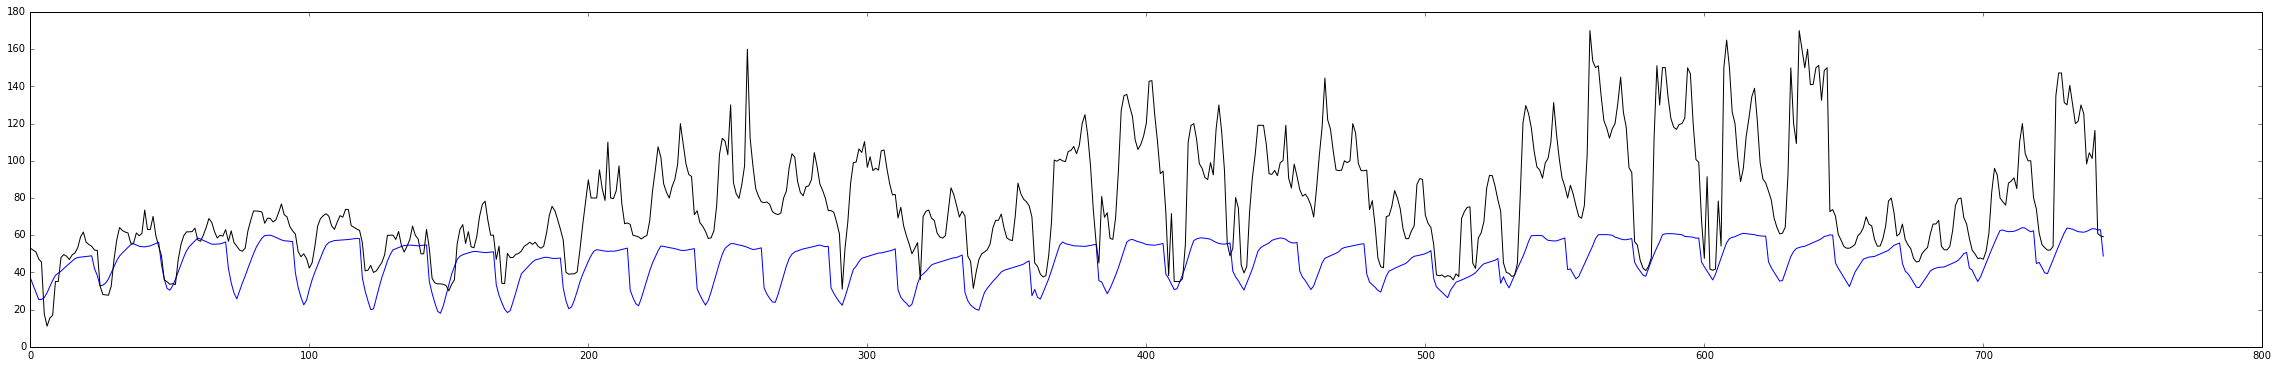

In [431]:
# predict
predicted_prices_2017_jan = neural.predict(timestamp_2017_jan)
# plot
plot_raw_and_predicted(raw_prices_2017_jan, predicted_prices_2017_jan)
print("Loss: " + str(loss(raw_prices_2017_jan, predicted_prices_2017_jan)))

Standardized

Loss: 1688.14873866


/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


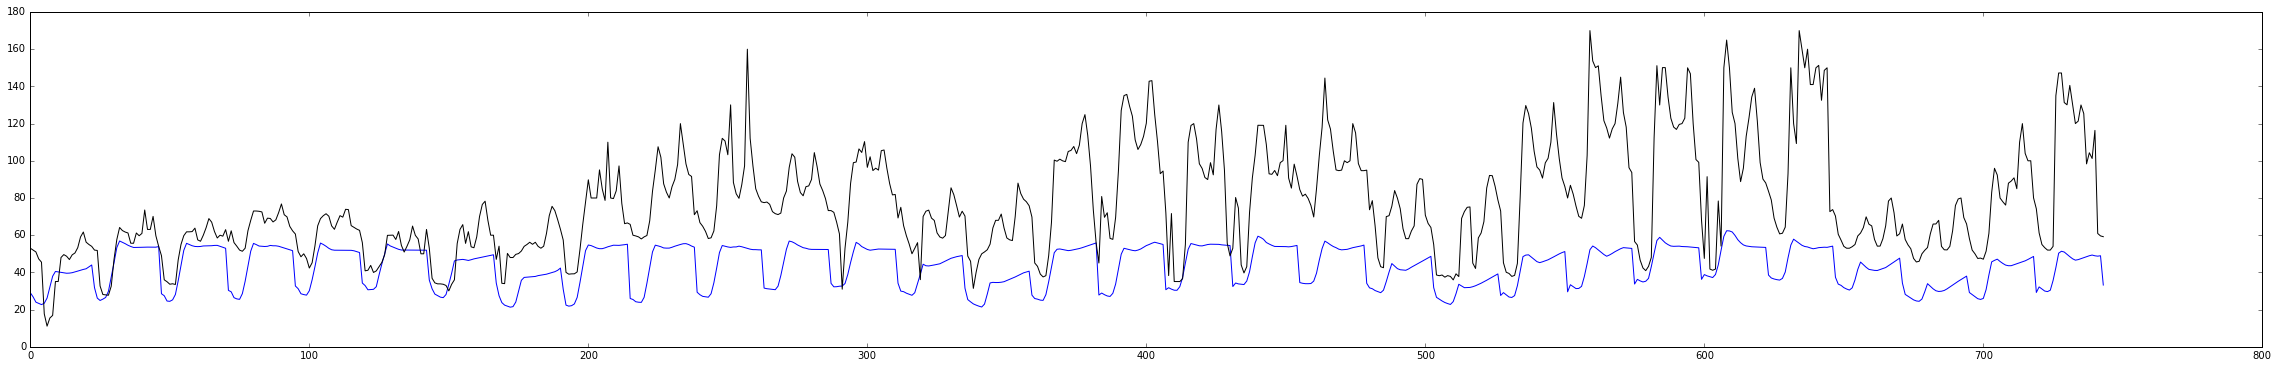

In [432]:
# standardize
timestamp_2017_jan_std = timestamp_2016_scaler.transform(timestamp_2017_jan)
# predict
predicted_prices_2017_jan = neural_std.predict(timestamp_2017_jan_std)
# plot
plot_raw_and_predicted(raw_prices_2017_jan, predicted_prices_2017_jan)
print("Loss: " + str(loss(raw_prices_2017_jan, predicted_prices_2017_jan)))

# Predict 2016

Loss: 66.9474381903


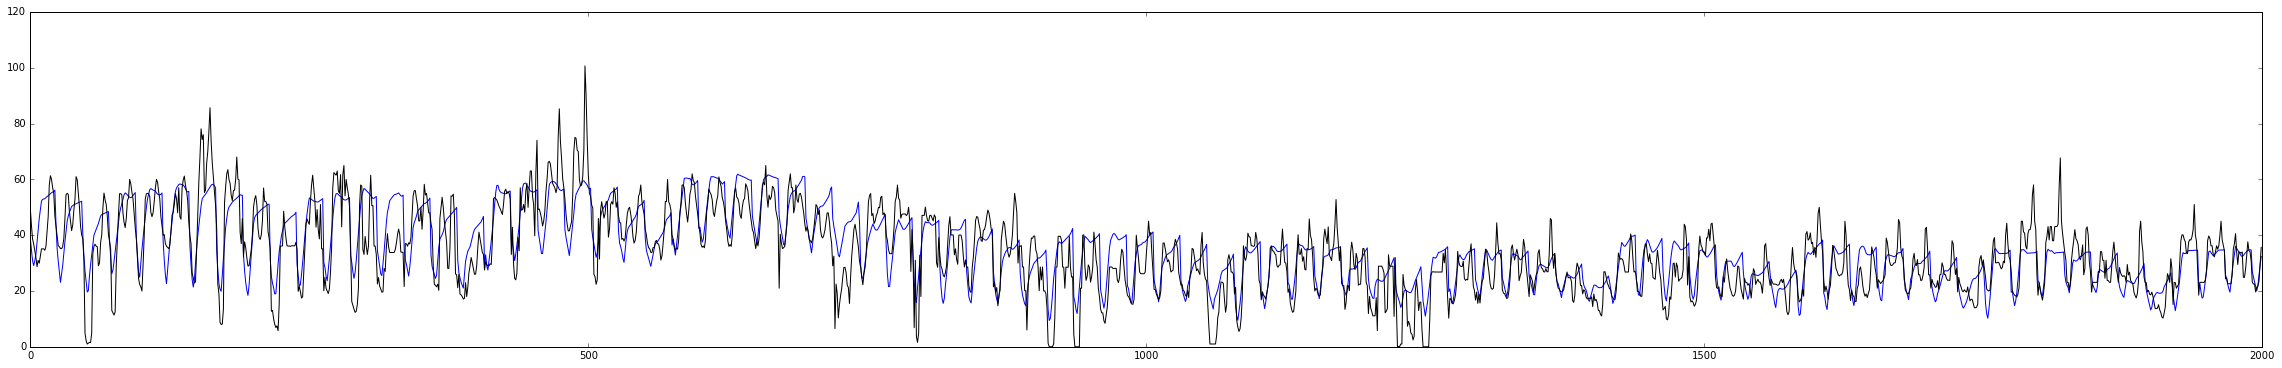

In [434]:
# Prediction on non-standardized data
predicted_prices_2016 = neural.predict(timestamp_2016)
plot_raw_and_predicted(prices_2016, predicted_prices_2016, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted_prices_2016)))

Loss: 59.5006320196


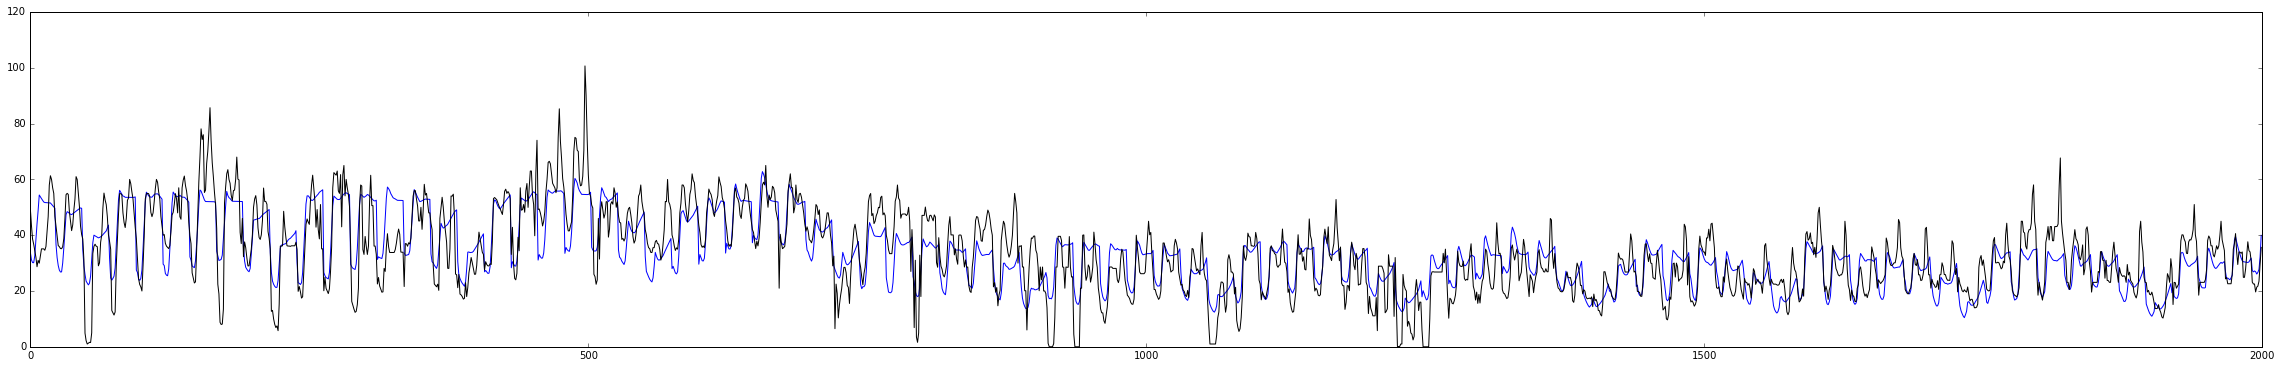

In [435]:
# Prediction on STANDARDIZED data
predicted_prices_2016 = neural_std.predict(timestamp_2016_std)
plot_raw_and_predicted(prices_2016, predicted_prices_2016, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted_prices_2016)))

## Append average daily weather data

Append  
'povp. dnevna T [°C]',  
'količina padavin [mm]',  
'višina novega snega [cm]',  
'oblačnost [%]'

Loss: 36.6097958064


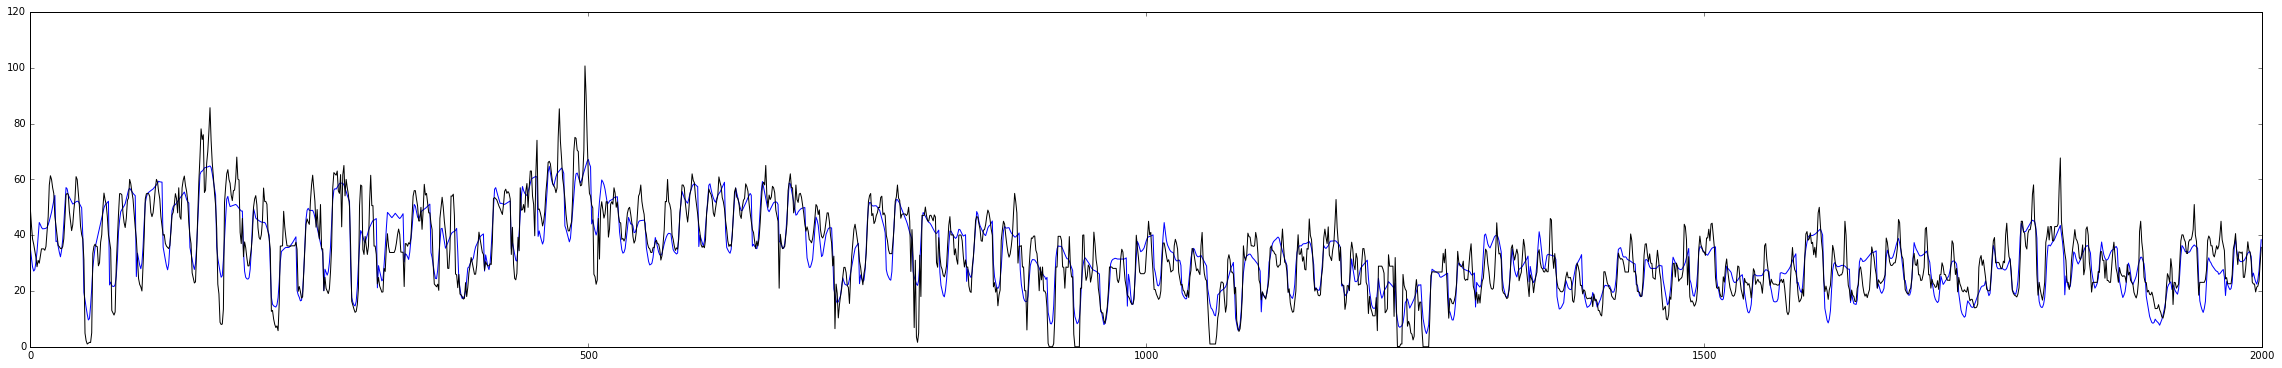

In [437]:
# fit the model
neural_pucnik_30303030 = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural_pucnik_30303030.fit(timestamp_weather_pucnik_2016_std, prices_2016)

# predict
predicted_prices_2016_pucnik = neural_pucnik_30303030.predict(timestamp_weather_pucnik_2016_std)

# plot
plot_raw_and_predicted(prices_2016, predicted_prices_2016_pucnik, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted_prices_2016_pucnik)))

Loss: 33.6457263877


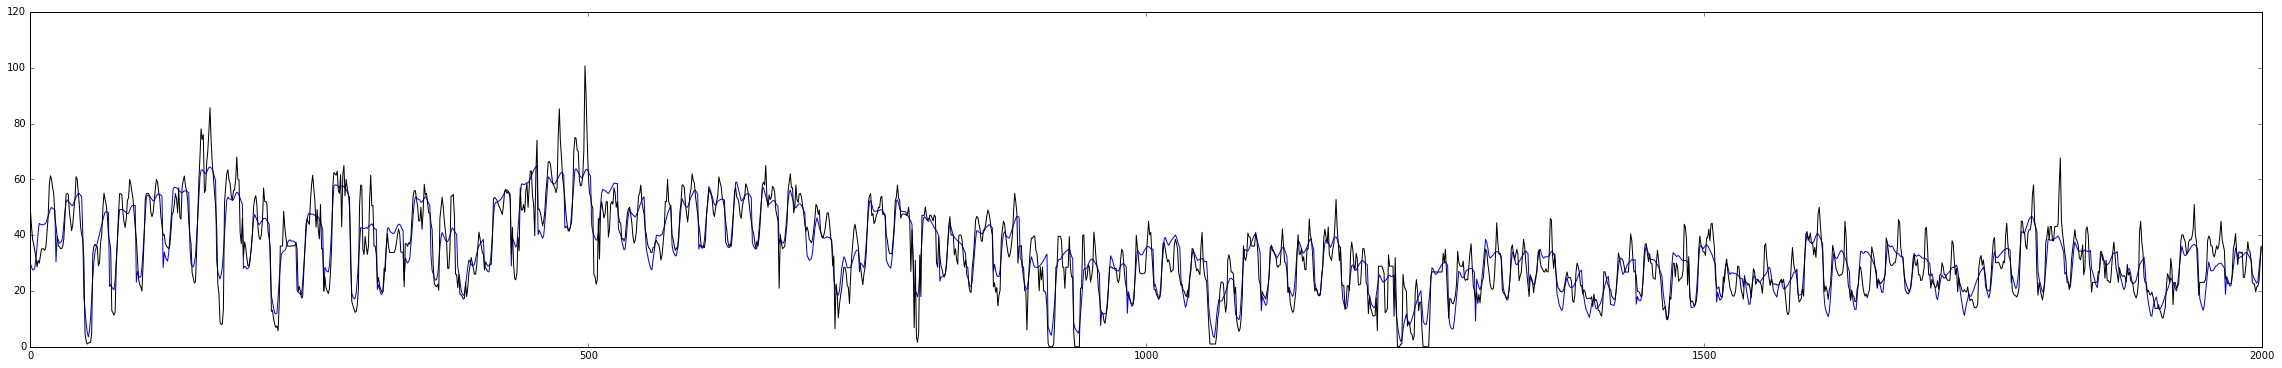

In [438]:
# fit the model
neural_pucnik_100100 = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, 100))
neural_pucnik_100100.fit(timestamp_weather_pucnik_2016_std, prices_2016)

# predict
predicted_prices_2016_pucnik = neural_pucnik_100100.predict(timestamp_weather_pucnik_2016_std)

# plot
plot_raw_and_predicted(prices_2016, predicted_prices_2016_pucnik, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted_prices_2016_pucnik)))

Loss: 29.0248846697


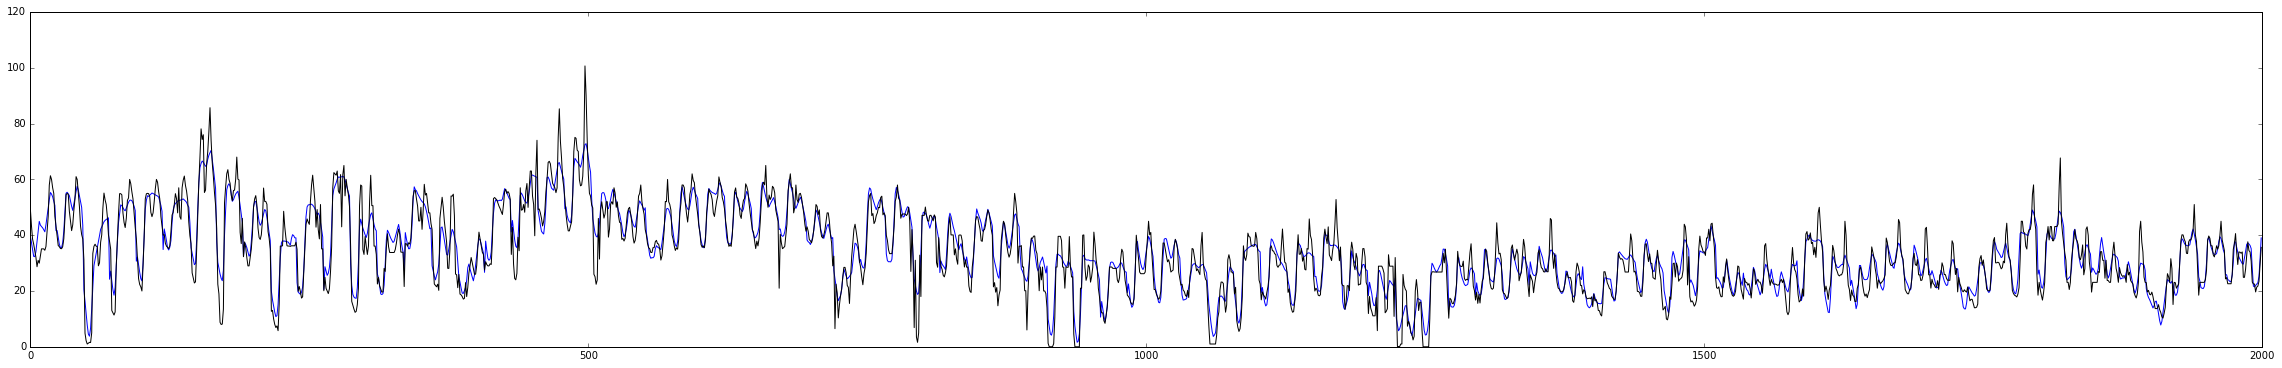

In [439]:
# fit the model
neural_pucnik_100100100 = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, 100, 100))
neural_pucnik_100100100.fit(timestamp_weather_pucnik_2016_std, prices_2016)

# predict
predicted_prices_2016_pucnik = neural_pucnik_100100100.predict(timestamp_weather_pucnik_2016_std)

# plot
plot_raw_and_predicted(prices_2016, predicted_prices_2016_pucnik, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted_prices_2016_pucnik)))

Loss: 27.6882849269


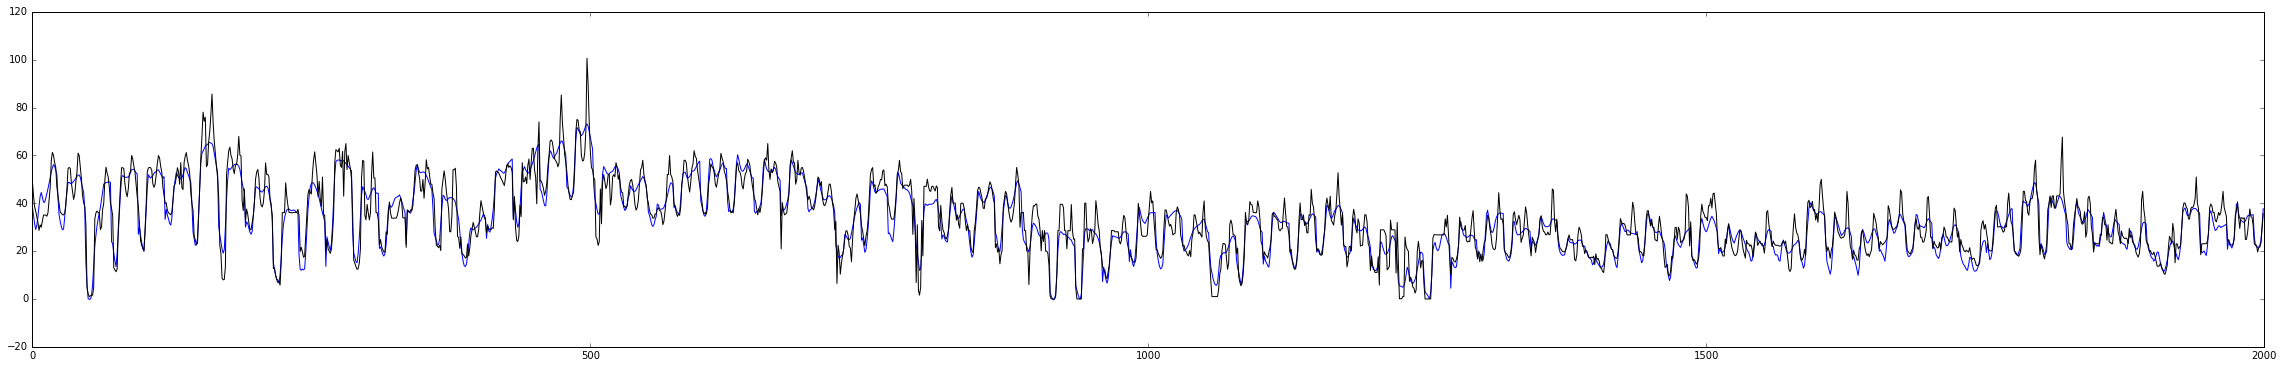

In [440]:
# fit the model
neural_pucnik_100100100100 = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))
neural_pucnik_100100100100.fit(timestamp_weather_pucnik_2016_std, prices_2016)

# predict
predicted_prices_2016_pucnik = neural_pucnik_fit_100100100100.predict(timestamp_weather_pucnik_2016_std)

# plot
plot_raw_and_predicted(prices_2016, predicted_prices_2016_pucnik, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted_prices_2016_pucnik)))

## Predict with NN on January data

In [469]:
def plot_true_and_pred(model, P, true, plot=True, from_=0, to_=2000):
    # predict
    pred = model.predict(P)
    # plot
    if plot:
        plot_raw_and_predicted(true, pred, from_, to_)
    # print error
    print("Loss: " + str(loss(true, pred)))

Loss: 1699.69617551


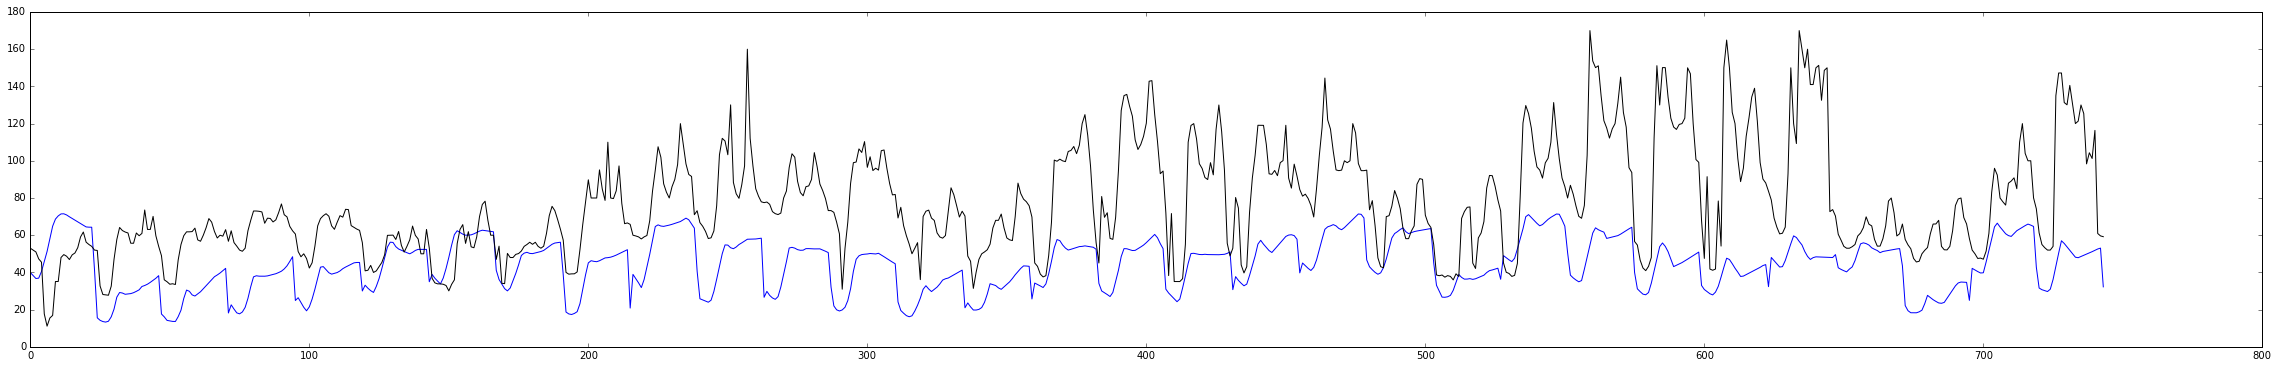

In [453]:
plot_true_and_pred(neural_pucnik_30303030, timestamp_weather_pucnik_2017_jan_std, raw_prices_2017_jan)

Loss: 1668.31796535


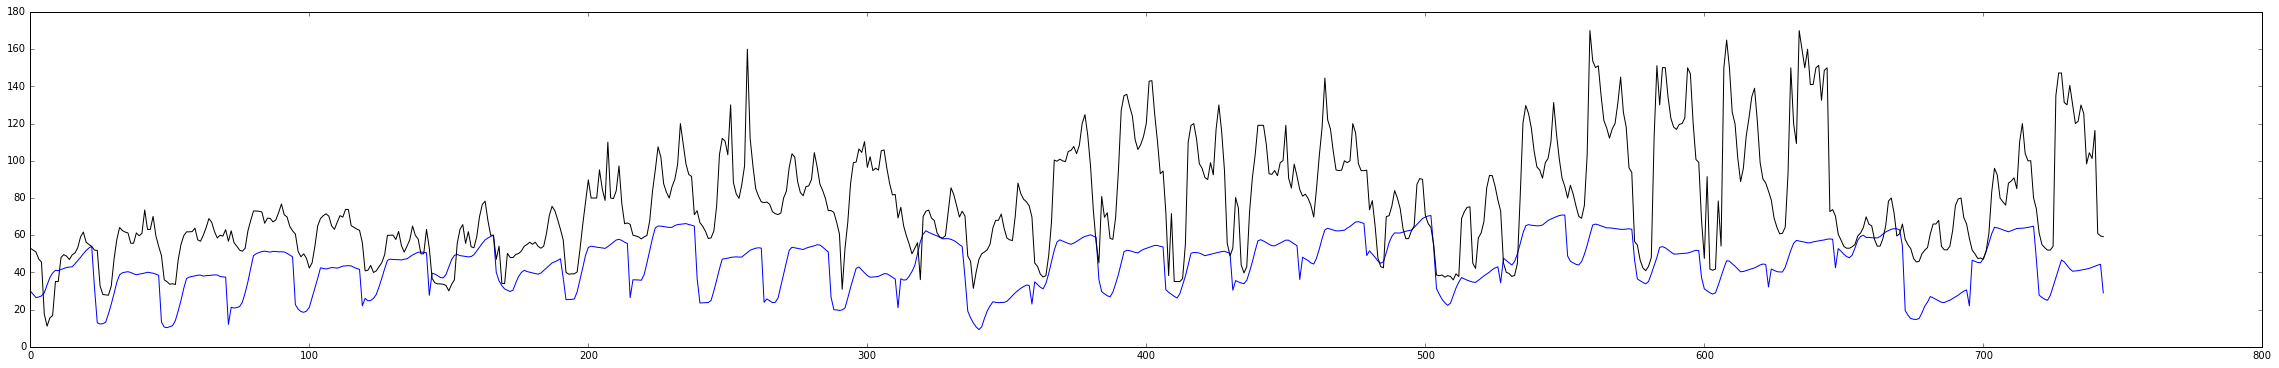

In [454]:
plot_true_and_pred(neural_pucnik_100100, timestamp_weather_pucnik_2017_jan_std, raw_prices_2017_jan)

Loss: 1886.04297658


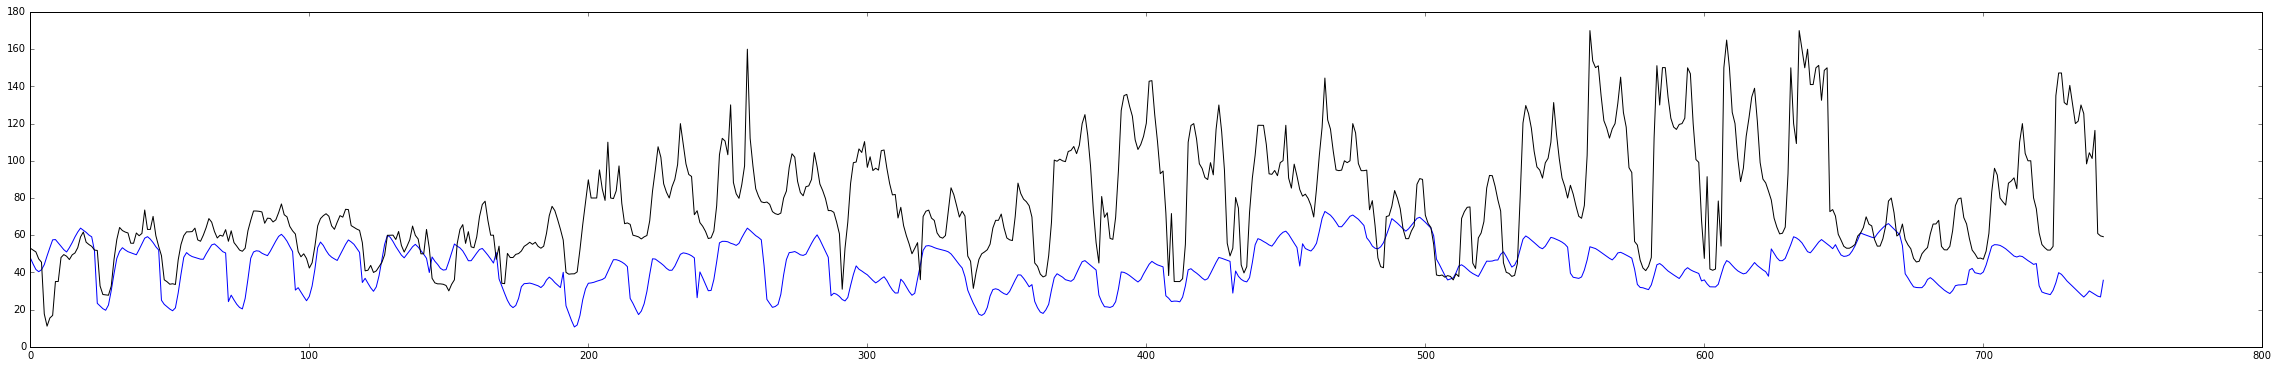

In [456]:
plot_true_and_pred(neural_pucnik_100100100, timestamp_weather_pucnik_2017_jan_std, raw_prices_2017_jan)

Loss: 1867.7695661


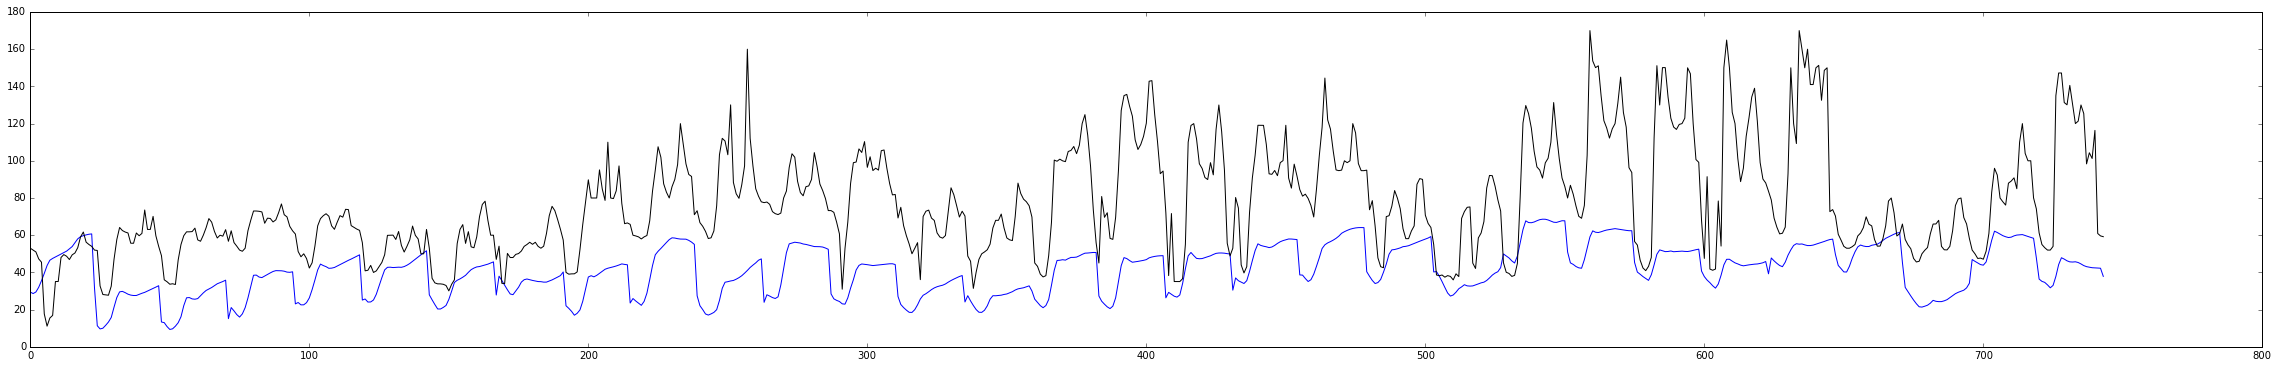

In [455]:
plot_true_and_pred(neural_pucnik_100100100100, timestamp_weather_pucnik_2017_jan_std, raw_prices_2017_jan)

## Include shuffling

In [571]:
from sklearn.utils import shuffle

In [572]:
# shuffle training data
timestamp_weather_pucnik_2016_std_sh, prices_2016_sh = shuffle(timestamp_weather_pucnik_2016_std, prices_2016)

In [573]:
# fit the model
neural_pucnik = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))
neural_pucnik.fit(timestamp_weather_pucnik_2016_std_sh, prices_2016_sh)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Loss: 19.7381844002


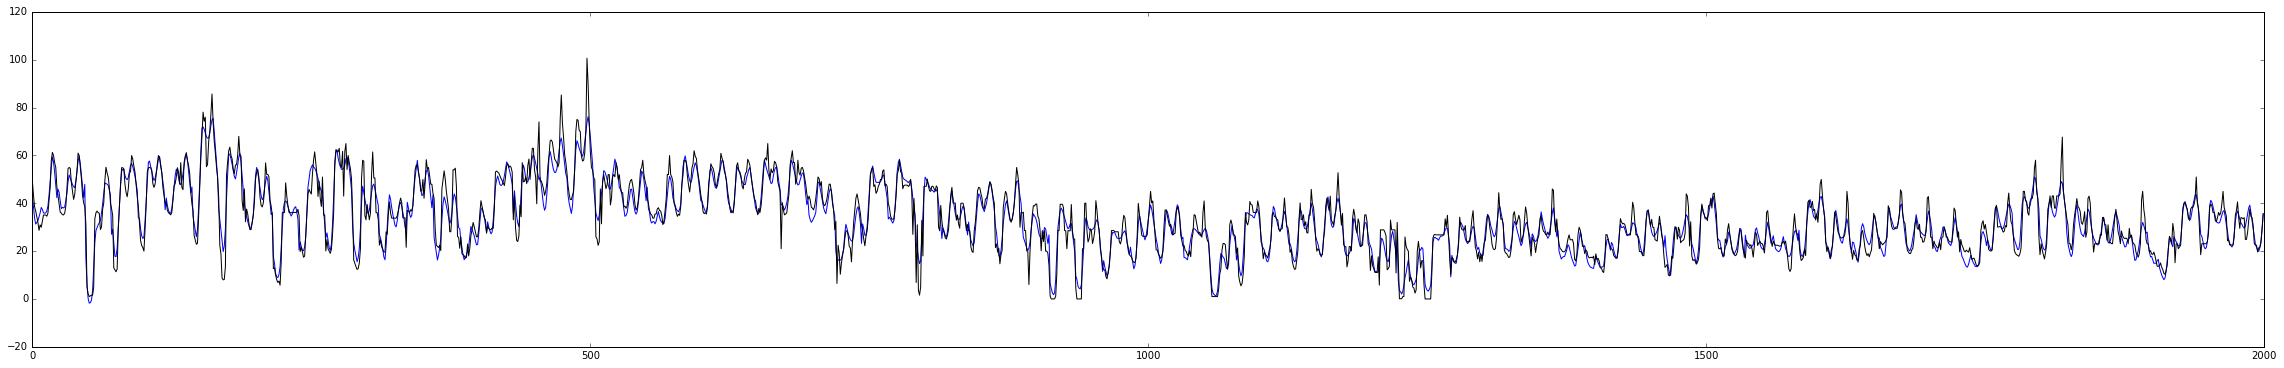

In [470]:
# plot loss 2016
plot_true_and_pred(neural_pucnik, timestamp_weather_pucnik_2016_std, prices_2016, plot=True)

Loss: 2138.91957413


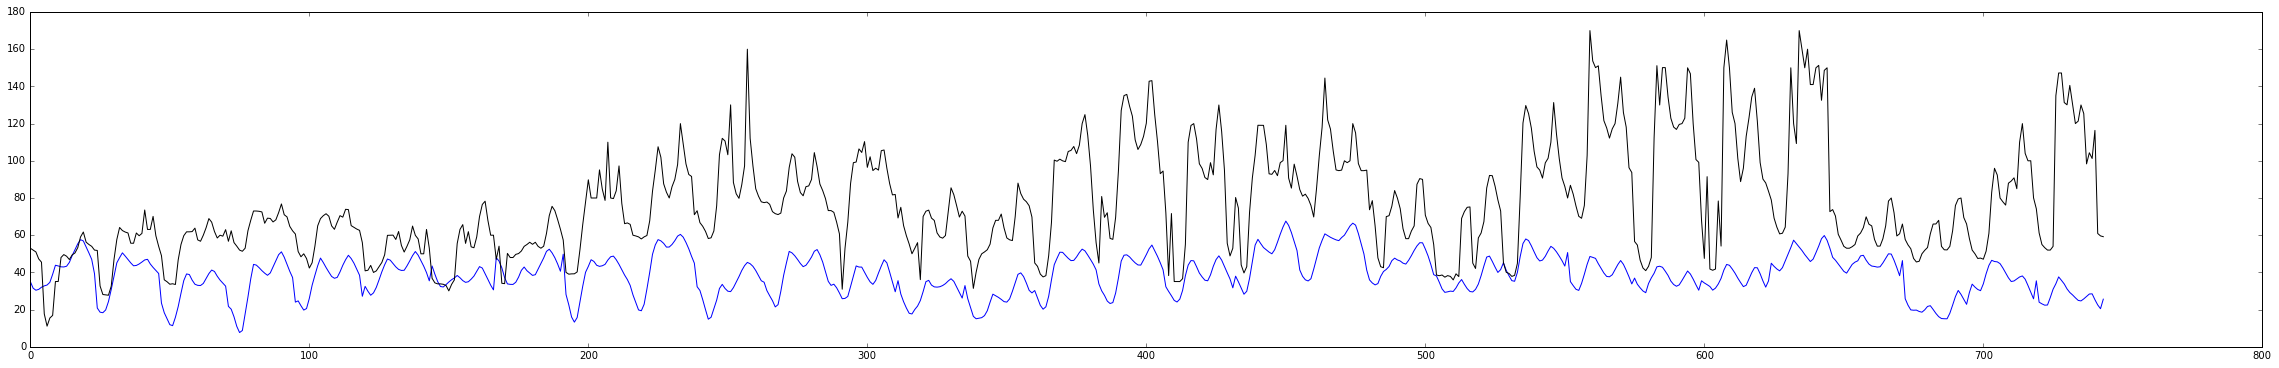

In [471]:
# print loss January
plot_true_and_pred(neural_pucnik, timestamp_weather_pucnik_2017_jan_std, raw_prices_2017_jan, plot=True)

#### Compare by Cross-Validation

In [472]:
# model
neural_pucnik_100100100100 = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))
neural_pucnik_30303030 = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))

In [473]:
# non-random 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_2016_std, prices_2016, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 161.96 (+/- 329.38)


In [474]:
# shuffled 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_2016_std_sh, prices_2016_sh, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 37.48 (+/- 14.34)


In [475]:
# non-random 30 30 30 30
scores = cross_val_score(neural_pucnik_30303030, timestamp_weather_pucnik_2016_std, prices_2016, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 147.46 (+/- 219.28)


In [476]:
# random 30 30 30 30
scores = cross_val_score(neural_pucnik_30303030, timestamp_weather_pucnik_2016_std_sh, prices_2016_sh, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 49.41 (+/- 10.02)


## Append demand

In [566]:
consumption_2016 = load_power_consumption_2016(False)

# Load demand
# Warning: Decenber 2016 is missing for consumption
tmp = Prices(consumption_2016[:, 1], consumption_2016[:, 0])
consumption_2016 = tmp.prices.astype(float)

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!


In [568]:
# Combine demand with the 'previous' training data
# Missing December is considered by removing December from the 'old' training data
n = len(consumption_2016)
timestamp_weather_pucnik_demand_2016_ = np.column_stack((timestamp_weather_pucnik_2016[0:n], consumption_2016))
prices_2016_ = prices_2016[0:n] # December missing

In [569]:
# standardize
std_demand = StandardScaler()
std_demand.fit(timestamp_weather_pucnik_demand_2016_)
timestamp_weather_pucnik_demand_2016_std_ = std_demand.transform(timestamp_weather_pucnik_demand_2016_)

# shuffle
timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_ = sklearn.utils.shuffle(
    timestamp_weather_pucnik_demand_2016_std_, prices_2016_)

In [574]:
# shuffled 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_2016_std_sh, prices_2016_sh, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 36.73 (+/- 12.46)


In [575]:
# shuffled 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 29.93 (+/- 7.32)


### Correlation between consumption and price

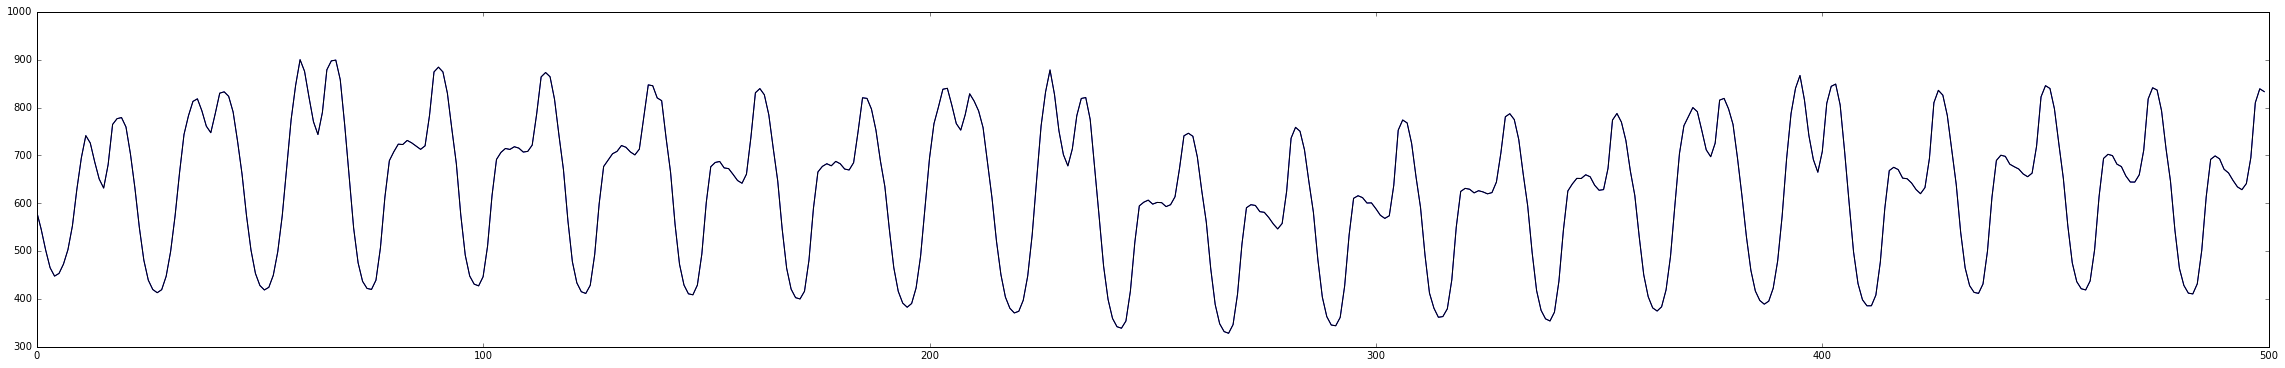

In [585]:
# Plot consumption
plot_raw_and_predicted(consumption_2016, consumption_2016, 0, 500)

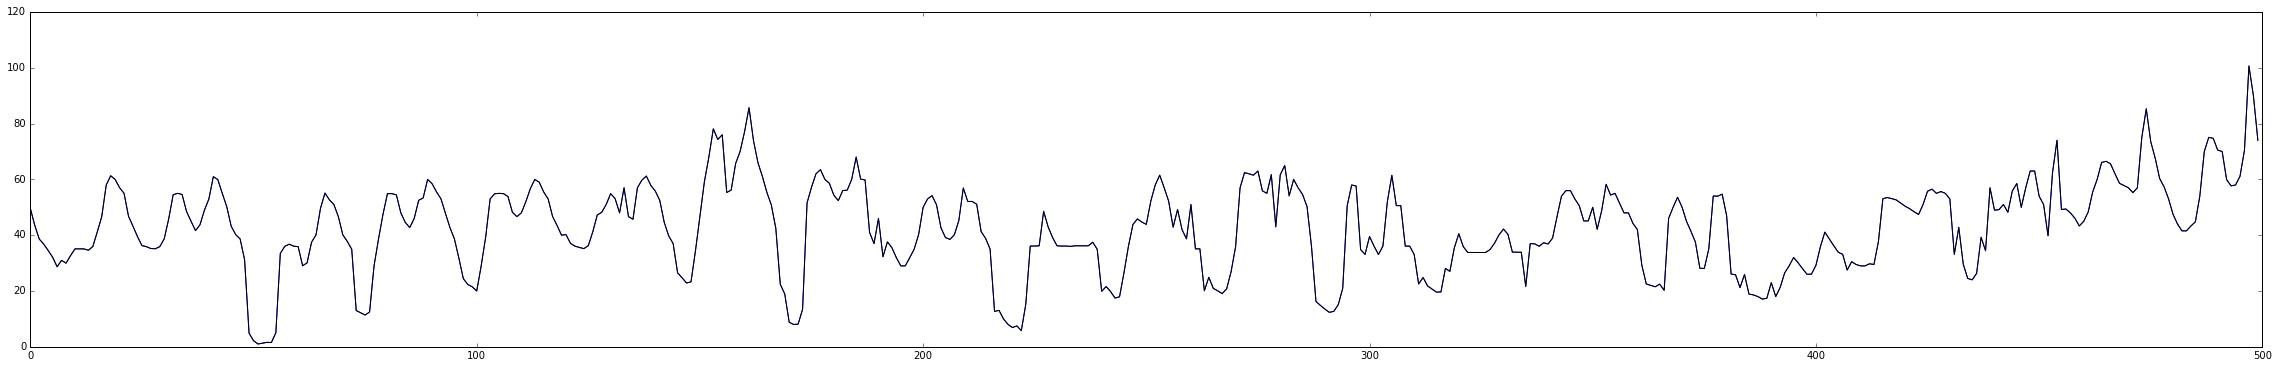

In [586]:
plot_raw_and_predicted(prices_2016_, prices_2016_, 0, 500)

We can see that demand is much more stable than price. Weekends are clearly noticable. Also 1st, 2nd and 3rd January (holidays). Therefore, it may be sensible to predict demand which is then used for price prediction.

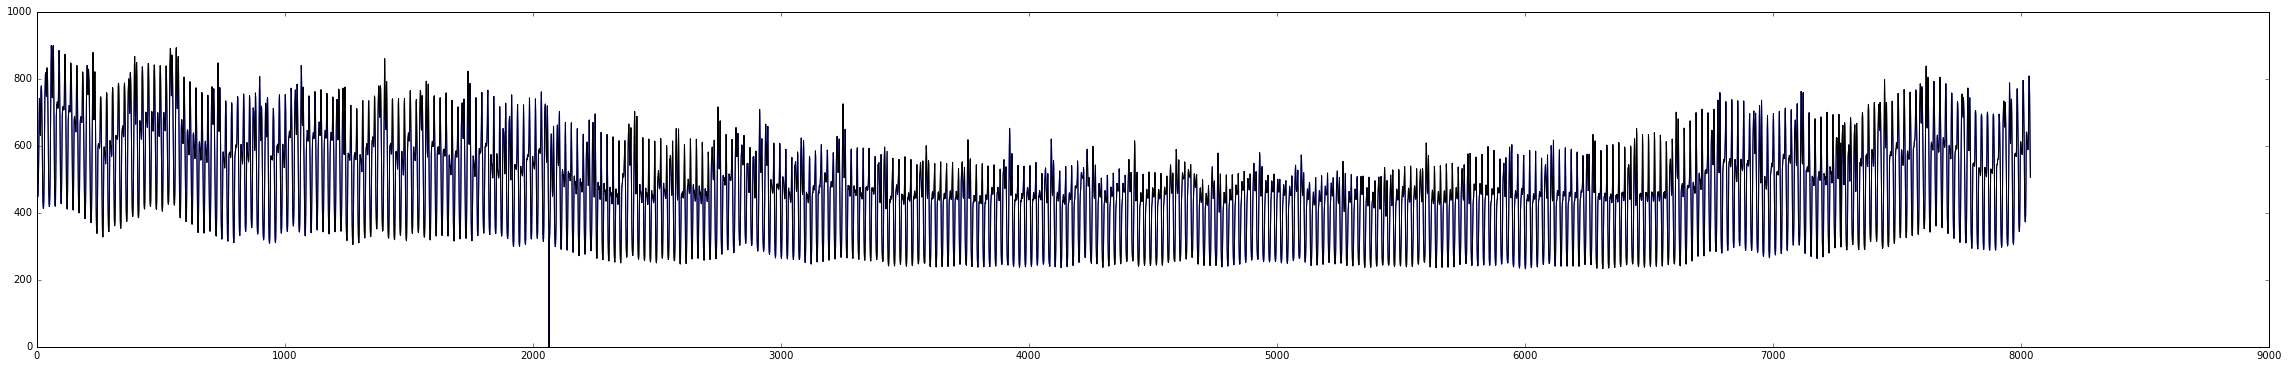

In [587]:
# Plot consumption
plot_raw_and_predicted(consumption_2016, consumption_2016)

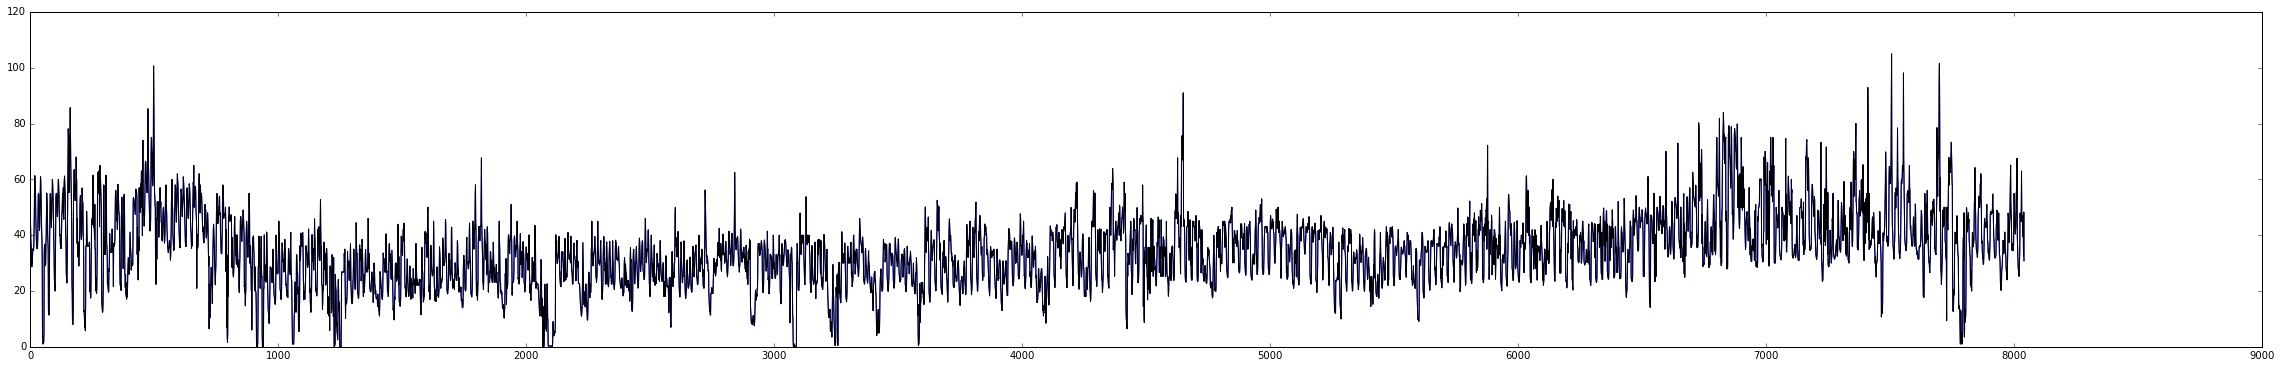

In [596]:
# Plot prices
plot_raw_and_predicted(prices_2016_, prices_2016_)

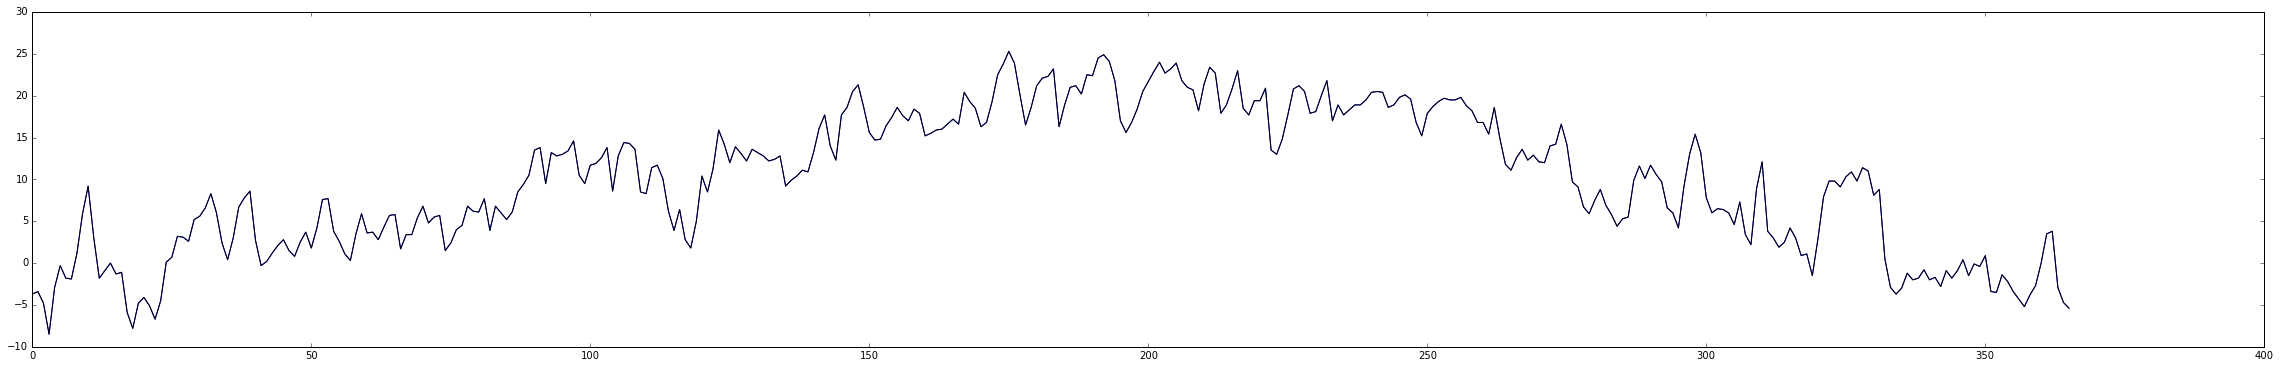

In [595]:
# Plot temperature
temp = weather_pucnik_2016.data[:,0]
plot_raw_and_predicted(temp, temp)

## Add PCA

Standardization has to be done first, then PCA!

[ 0.23762791  0.15950552  0.1331012   0.11703808  0.1076334   0.09339966
  0.07142484  0.05988092  0.02038848]


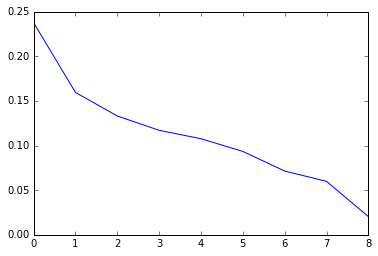

In [612]:
from sklearn import decomposition

# fit pca
pca = decomposition.PCA()
pca.fit(timestamp_weather_pucnik_demand_2016_std_sh_)

# plot variance
print(pca.explained_variance_ratio_) 
pyplot.plot(pca.explained_variance_ratio_) 

In [618]:
def score_based_on_components(n_comp):
    # take first n_comp dimensions
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(timestamp_weather_pucnik_demand_2016_std_sh_)
    timestamp_weather_pucnik_demand_2016_std_sh_pca_ = pca.transform(timestamp_weather_pucnik_demand_2016_std_sh_)

    # shuffled 100 100 100 100
    scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_demand_2016_std_sh_pca_, prices_2016_sh_, 
                             cv=10, scoring='neg_mean_squared_error')
    print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

In [620]:
score_based_on_components(2)

Accuracy: 128.37 (+/- 20.02)


In [621]:
score_based_on_components(7)

Accuracy: 40.16 (+/- 8.47)


In [619]:
score_based_on_components(8)

Accuracy: 33.27 (+/- 7.69)


# Deep Learning

In [622]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [627]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(DIM+1, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

In [630]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(DIM+1, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 64.16 (+/- 24.39)


In [632]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(30, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=15, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 77.76 (+/- 10.25)


In [633]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(100, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 50.97 (+/- 10.42)


In [634]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(100, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 61.08 (+/- 10.53)


## Model and Predict based on 24-dimensions

## Drop out 10% of links in NN

## Interpolate temperature and predict 2016

In [148]:
def generale_list_of_hours_7_14_21(n_days):
    """This is the example of the first 3 [7, 14, 21, 31, 38, 45, 55, 62, 69]"""
    if n_days <= 0:
        return []
    # Add initial hours
    array = [7, 14, 21]
    # Each next hour can be computed by adding 24h to the previous ones
    for i in range(1, n_days):
        array += [array[-3]+24, array[-2]+24, array[-1]+24]
    return array

In [155]:
# load weather data
#weather_pucnik = test_load_pucnik()

#weather_pucnik_data_list = np.reshape(weather_pucnik.data, weather_pucnik.data.size))

SyntaxError: invalid syntax (<ipython-input-155-3de7bbedf190>, line 4)

## Include Demand Parameter